In [62]:
# --- Library Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [63]:
# --- Load Sales Data ---
file_path = "/Users/ashikurrahmanshihab/GitHub/Hybrid-Demand-Forecasting-and-Reorder-Point-Planning-Using-AROPHET-in-the-Pharmaceutical-Industry/Alton_20_Sales_Data_2014_2024.xlsx"

# Load Excel file into DataFrame
try:
    sales_data = pd.read_excel(file_path)
    print("✅ Sales data loaded successfully.")
except FileNotFoundError:
    print("❌ File not found. Please check the file path.")
except Exception as e:
    print(f"❌ Error loading file: {e}")

# --- Preview Raw Data ---
print("\n🔍 First 5 rows of raw data:")
display(sales_data.head())

✅ Sales data loaded successfully.

🔍 First 5 rows of raw data:


,ds,y,marketing_spend,doctor_visits,disease_trend,stock_level,lead_time_days,safety_stock,shelf_life_months,MOQ
0,2014-01-01,1187.000000,892,5048,346,6889,14,500,36,3000
1,2014-02-01,1332.860756,1555,4613,395,6701,7,1000,12,3000
2,2014-03-01,1342.644005,1301,5012,230,6291,14,1000,12,2000
3,2014-04-01,1407.575042,1755,5248,328,5841,14,500,36,1000
4,2014-05-01,1386.842733,1262,5725,267,7576,7,500,12,1000


In [64]:
# --- Ensure correct column names ---
required_cols = ['ds', 'y', 'marketing_spend', 'doctor_visits', 'disease_trend', 'stock_level']
missing_cols = [col for col in required_cols if col not in sales_data.columns]

if missing_cols:
    raise ValueError(f"❌ Missing required columns in sales_data: {missing_cols}")

# --- Initialize Prophet with external regressors ---
m = Prophet()

# Add regressors
for reg in ['marketing_spend', 'doctor_visits', 'disease_trend', 'stock_level']:
    m.add_regressor(reg)

# --- Fit the model ---
m.fit(sales_data[required_cols])  # Pass only needed columns

01:59:40 - cmdstanpy - INFO - Chain [1] start processing
01:59:40 - cmdstanpy - INFO - Chain [1] done processing


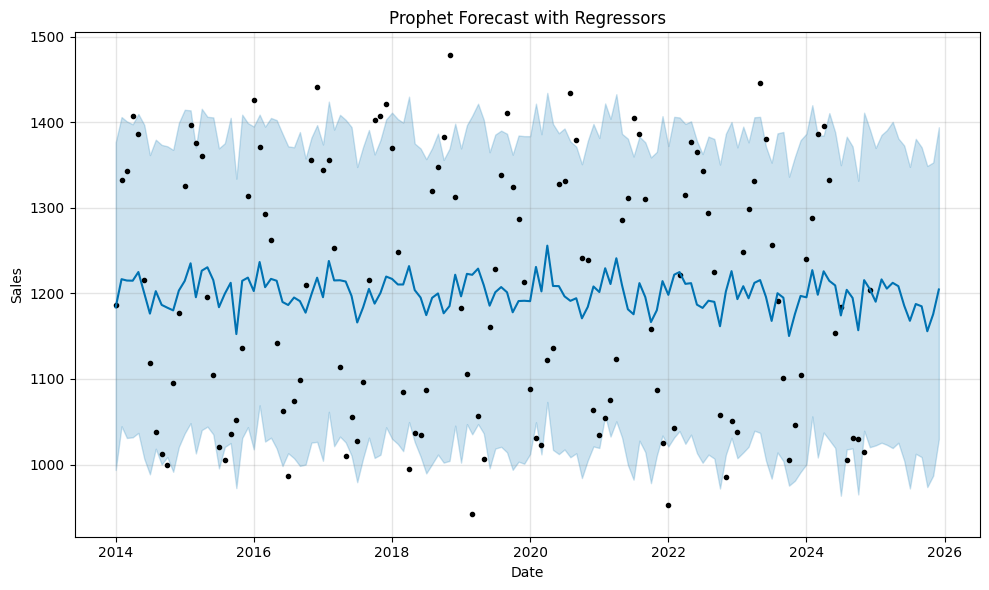

In [65]:
# --- Create future dataframe (12 months ahead) ---
future = m.make_future_dataframe(periods=12, freq='MS')

# --- Merge existing regressors into the future dataframe ---
regressors = ['marketing_spend', 'doctor_visits', 'disease_trend', 'stock_level']
future = pd.merge(future, sales_data[['ds'] + regressors], on='ds', how='left')

# --- Interpolate missing regressor values ---
for col in regressors:
    future[col] = future[col].interpolate(method='linear', limit_direction='forward')

# Optional: Fill any remaining NaNs (e.g., trailing values after interpolation)
future[regressors] = future[regressors].fillna(method='ffill')

# --- Forecast with Prophet ---
forecast = m.predict(future)

# --- Plot the forecast ---
fig = m.plot(forecast)
plt.title("Prophet Forecast with Regressors")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
from prophet.diagnostics import cross_validation, performance_metrics

# --- Time Series Cross-Validation ---
print("⏳ Running cross-validation. This may take some time...")
df_cv = cross_validation(
    model=m,
    initial='1460 days',    # ~4 years of initial training
    period='180 days',      # step size: re-train every 6 months
    horizon='365 days',     # forecast window
    parallel="processes"    # optional: speed up with multiprocessing
)

# --- Calculate Performance Metrics ---
df_p = performance_metrics(df_cv)

# --- Display metrics ---
print("\n📊 Available metrics:")
print(df_p.columns.tolist())

print("\n✅ Forecast Accuracy (average across folds):")
print(df_p[['horizon', 'mae', 'rmse', 'mape', 'coverage']])

⏳ Running cross-validation. This may take some time...


02:00:44 - cmdstanpy - INFO - Chain [1] start processing
02:00:44 - cmdstanpy - INFO - Chain [1] start processing
02:00:44 - cmdstanpy - INFO - Chain [1] start processing
02:00:44 - cmdstanpy - INFO - Chain [1] start processing
02:00:44 - cmdstanpy - INFO - Chain [1] start processing
02:00:44 - cmdstanpy - INFO - Chain [1] start processing
02:00:44 - cmdstanpy - INFO - Chain [1] start processing
02:00:44 - cmdstanpy - INFO - Chain [1] start processing
02:00:44 - cmdstanpy - INFO - Chain [1] done processing
02:00:44 - cmdstanpy - INFO - Chain [1] start processing
02:00:44 - cmdstanpy - INFO - Chain [1] done processing
02:00:44 - cmdstanpy - INFO - Chain [1] done processing
02:00:44 - cmdstanpy - INFO - Chain [1] done processing
02:00:44 - cmdstanpy - INFO - Chain [1] done processing
02:00:44 - cmdstanpy - INFO - Chain [1] start processing
02:00:44 - cmdstanpy - INFO - Chain [1] done processing
02:00:44 - cmdstanpy - INFO - Chain [1] start processing
02:00:44 - cmdstanpy - INFO - Chain [


📊 Available metrics:
['horizon', 'mse', 'rmse', 'mae', 'mape', 'mdape', 'smape', 'coverage']

✅ Forecast Accuracy (average across folds):
     horizon         mae        rmse      mape  coverage
0    36 days  198.518099  215.042552  0.168166  0.333333
1    40 days  205.765741  223.565574  0.176895  0.333333
2    42 days  227.512805  246.540926  0.191395  0.266667
3    46 days  226.658006  245.476904  0.191201  0.266667
4    47 days  224.623708  243.972458  0.189348  0.266667
..       ...         ...         ...       ...       ...
132 356 days  199.677640  214.545488  0.171828  0.333333
133 359 days  187.821378  203.263735  0.158995  0.400000
134 362 days  176.015848  192.800548  0.151853  0.466667
135 364 days  180.720932  197.393290  0.154694  0.400000
136 365 days  173.097498  194.681580  0.149274  0.400000

[137 rows x 5 columns]


02:00:44 - cmdstanpy - INFO - Chain [1] done processing


In [67]:
r2_per_fold = df_cv.groupby('cutoff').apply(
    lambda df: r2_score(df['y'], df['yhat'])
)

print("R² per fold:")
print(r2_per_fold)
print(f"\nMean R² across folds: {r2_per_fold.mean():.4f}")

R² per fold:
cutoff
2018-01-02   -0.782850
2018-07-01   -0.790834
2018-12-28   -0.752833
2019-06-26   -1.476442
2019-12-23   -1.921266
2020-06-20   -1.326778
2020-12-17   -1.130219
2021-06-15   -0.844705
2021-12-12   -0.828071
2022-06-10   -0.667964
2022-12-07   -0.478818
2023-06-05   -0.361827
2023-12-02   -0.250792
dtype: float64

Mean R² across folds: -0.8933


In [68]:
import pandas as pd
from prophet import Prophet

# Load the Excel file
file_path = "/Users/ashikurrahmanshihab/GitHub/Hybrid-Demand-Forecasting-and-Reorder-Point-Planning-Using-AROPHET-in-the-Pharmaceutical-Industry/Alton_20_Sales_Data_2014_2024.xlsx"
df_raw = pd.read_excel(file_path)

# Clean the data
if df_raw.iloc[0, 0] == "Month":
    df_clean = df_raw.iloc[1:].reset_index(drop=True)
else:
    df_clean = df_raw.copy()

df_clean = df_clean.iloc[:, :2]
df_clean.columns = ['ds', 'y']

df_clean['y'] = (
    df_clean['y']
    .astype(str)
    .str.replace(r'[^0-9.]', '', regex=True)
    .replace('', pd.NA)
    .astype(float)
)

df_clean['ds'] = pd.to_datetime(df_clean['ds'], errors='coerce')
df_clean.dropna(inplace=True)

# Prophet Forecasting
model = Prophet(yearly_seasonality=True)
model.fit(df_clean)

# Forecast 12 future months
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

# Filter forecast for 2025
forecast_2025 = forecast[forecast['ds'].dt.year == 2025].copy()


01:59:41 - cmdstanpy - INFO - Chain [1] start processing
01:59:41 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
# --- Bootstrapped Confidence Intervals for Prophet Forecast ---

# Merge actuals with Prophet forecast to compute residuals
df_with_yhat = pd.merge(df_clean, forecast[['ds', 'yhat']], on='ds')
df_with_yhat['residual'] = df_with_yhat['y'] - df_with_yhat['yhat']
residuals = df_with_yhat['residual'].values

# Number of bootstrap samples and forecast horizon (length of forecast_2025)
n_boot = 1000
forecast_horizon = forecast_2025.shape[0]  # Typically 12 months

# Initialize array to store bootstrap samples
boot_samples = np.empty((n_boot, forecast_horizon))

# Generate bootstrapped forecasts by adding sampled residuals to Prophet forecasts
for i in range(n_boot):
    sampled_residuals = np.random.choice(residuals, size=forecast_horizon, replace=True)
    boot_samples[i] = forecast_2025['yhat'].values + sampled_residuals

# Calculate bootstrap confidence intervals (2.5% and 97.5%) and median (50%)
forecast_2025['boot_lower'] = np.percentile(boot_samples, 2.5, axis=0)
forecast_2025['boot_upper'] = np.percentile(boot_samples, 97.5, axis=0)
forecast_2025['boot_median'] = np.percentile(boot_samples, 50, axis=0)


In [70]:
# --- Reorder Point (ROP) Calculation with Prophet Forecast ---

k = 1.0  # Risk factor: higher k → more conservative safety stock (e.g., k=1 ~ 84% CI)

# Calculate ROP = median forecast + k * (upper bound - median)
forecast_2025['prophet_rop'] = forecast_2025['boot_median'] + k * (
    forecast_2025['boot_upper'] - forecast_2025['boot_median']
)

# Round ROP to nearest integer and ensure no negative reorder points
forecast_2025['prophet_rop'] = forecast_2025['prophet_rop'].round().clip(lower=0)

# Alternative: Use standard deviation from bootstrap samples (if available)
rop = forecast_2025['boot_median'] + k * boot_samples.std(axis=0)

In [71]:
# --- Hybrid Forecast = Prophet + ARIMA Residuals ---

# Fit ARIMA(1,0,1) on Prophet residuals (from your merged data)
arima_model = ARIMA(df_with_yhat['residual'], order=(1, 0, 1)).fit()

# Forecast next 12 months residuals
arima_forecast = arima_model.forecast(steps=12)

# Take last 12 months from Prophet forecast (future months)
final_forecast = forecast.tail(12).copy()

# Add ARIMA residual correction to Prophet forecast for hybrid forecast
final_forecast['arima_correction'] = arima_forecast.values
final_forecast['yhat_hybrid'] = final_forecast['yhat'] + final_forecast['arima_correction']

# Filter hybrid forecast specifically for 2025 (optional)
hybrid_forecast_2025 = final_forecast[final_forecast['ds'].dt.year == 2025].copy()

# Display the relevant columns
print(hybrid_forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'arima_correction', 'yhat_hybrid']])

            ds         yhat   yhat_lower   yhat_upper  arima_correction  \
132 2025-01-01  1192.433375  1009.599955  1371.993795         51.123678   
133 2025-02-01  1219.575595  1024.311609  1395.717489         34.693197   
134 2025-03-01  1202.571416  1002.885699  1376.268037         23.596365   
135 2025-04-01  1219.812208  1041.364194  1405.935714         16.101778   
136 2025-05-01  1207.892911  1024.028008  1386.549406         11.040078   
137 2025-06-01  1191.164217   997.804824  1372.464146          7.621503   
138 2025-07-01  1174.128095   988.595942  1356.853366          5.312663   
139 2025-08-01  1192.163849  1019.442275  1372.833595          3.753317   
140 2025-09-01  1191.209650  1010.993138  1396.891583          2.700164   
141 2025-10-01  1162.932686   978.587773  1351.324679          1.988885   
142 2025-11-01  1187.411869   997.198781  1377.640996          1.508501   
143 2025-12-01  1205.173690  1017.997572  1385.938189          1.184059   

     yhat_hybrid  
132  

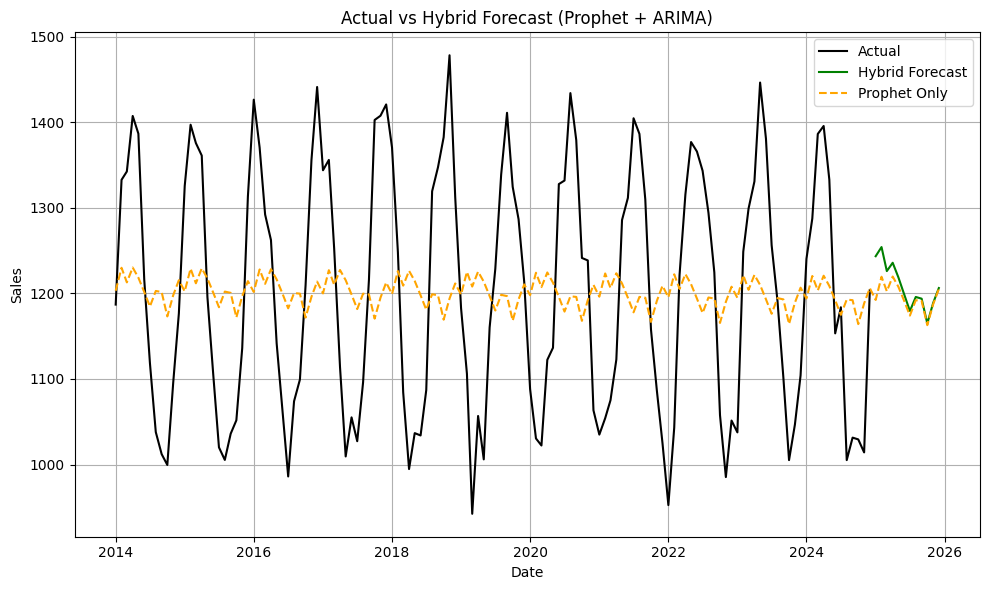

In [72]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# --- Step 1: Calculate residuals from Prophet ---
df_with_yhat = df_clean.merge(forecast[['ds', 'yhat']], on='ds', how='left')
df_with_yhat['residual'] = df_with_yhat['y'] - df_with_yhat['yhat']

# --- Step 2: Fit ARIMA on residuals ---
arima_model = ARIMA(df_with_yhat['residual'].dropna(), order=(1, 0, 1)).fit()

# --- Step 3: Forecast ARIMA residuals (next 12 months) ---
arima_pred = arima_model.forecast(steps=12)

# --- Step 4: Combine Prophet forecast + ARIMA residual correction ---
final_forecast = forecast.tail(12).copy()  # same time range as ARIMA forecast
final_forecast['yhat_hybrid'] = final_forecast['yhat'].values + arima_pred.values

# --- Step 5: Plot Hybrid Forecast ---
plt.figure(figsize=(10, 6))
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', color='black')
plt.plot(final_forecast['ds'], final_forecast['yhat_hybrid'], label='Hybrid Forecast', color='green')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Only', color='orange', linestyle='--')

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Actual vs Hybrid Forecast (Prophet + ARIMA)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [73]:
# Add ARIMA correction to forecast_2025
forecast_2025['arima_correction'] = arima_forecast.values  # your ARIMA residual forecast
forecast_2025['arophet'] = forecast_2025['yhat'] + forecast_2025['arima_correction']

# Now do the bootstrap
n_boot = 1000
forecast_horizon = len(forecast_2025)

boot_arophet_samples = np.empty((n_boot, forecast_horizon))
for i in range(n_boot):
    boot_resid = np.random.choice(residuals, size=forecast_horizon, replace=True)
    boot_arophet_samples[i] = forecast_2025['arophet'].values + boot_resid

forecast_2025['arophet_lower'] = np.percentile(boot_arophet_samples, 2.5, axis=0)
forecast_2025['arophet_upper'] = np.percentile(boot_arophet_samples, 97.5, axis=0)
forecast_2025['arophet_median'] = np.percentile(boot_arophet_samples, 50, axis=0)

# Calculate reorder point (ROP) with risk factor k (e.g., k=1.0)
forecast_2025['arophet_rop'] = forecast_2025['arophet_median'] + k * (
    forecast_2025['arophet_upper'] - forecast_2025['arophet_median']
)

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Align actuals and Prophet predictions on dates
merged_df = df_clean.merge(forecast[['ds', 'yhat']], on='ds', how='inner')
actual = merged_df['y'].values
prophet_pred = merged_df['yhat'].values

# ARIMA residual correction for history
arima_correction_hist = arima_model.predict(start=0, end=len(actual) - 1)
arophet_pred = prophet_pred + arima_correction_hist

# Accuracy metrics function
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

metrics = {
    'Model': ['Prophet', 'AROPHET'],
    'MAE': [mean_absolute_error(actual, prophet_pred),
            mean_absolute_error(actual, arophet_pred)],
    'RMSE': [np.sqrt(mean_squared_error(actual, prophet_pred)),
             np.sqrt(mean_squared_error(actual, arophet_pred))],
    'MAPE': [mape(actual, prophet_pred), mape(actual, arophet_pred)],
    'R2': [r2_score(actual, prophet_pred), r2_score(actual, arophet_pred)]
}
accuracy_df = pd.DataFrame(metrics)

# Merge hybrid forecast 'yhat_hybrid' into forecast_2025 by ds to avoid mismatch
forecast_2025 = forecast_2025.merge(
    final_forecast[['ds', 'yhat_hybrid']], on='ds', how='left'
)

# Use bootstrap median as baseline for ROP
forecast_2025['boot_median'] = forecast_2025['boot_median']

# Use bootstrap percentiles or prophet CI for ROP (adjust k factor)
k = 1.96  # z-value for 95% confidence

forecast_2025['prophet_rop'] = forecast_2025['yhat'] - k * (forecast_2025['yhat_upper'] - forecast_2025['yhat'])
forecast_2025['arophet_median'] = forecast_2025['yhat_hybrid']

# For hybrid ROP, use bootstrapped lower bound or adjust similarly:
forecast_2025['arophet_rop'] = forecast_2025['boot_lower']  # Or use a custom formula with k

# Display
print(accuracy_df)
print("\n2025 Forecast Table:")
print(forecast_2025[['ds', 'boot_median', 'prophet_rop', 'arophet_median', 'arophet_rop']])


     Model         MAE        RMSE       MAPE        R2
0  Prophet  128.674095  144.113781  10.900000  0.013341
1  AROPHET   65.259247   82.262064   5.507847  0.678519

2025 Forecast Table:
           ds  boot_median  prophet_rop  arophet_median  arophet_rop
0  2025-01-01  1190.158295   840.494952     1243.557053   984.677073
1  2025-02-01  1222.175982   874.337482     1254.268792  1011.819293
2  2025-03-01  1205.171804   862.126041     1226.167782   970.754023
3  2025-04-01  1234.255274   855.010134     1235.913986  1012.055906
4  2025-05-01  1225.183572   857.726179     1218.932989  1000.136609
5  2025-06-01  1188.889137   835.816357     1198.785720   985.051732
6  2025-07-01  1191.418756   815.986563     1179.440758   966.371793
7  2025-08-01  1201.027490   838.051146     1195.917166   984.407547
8  2025-09-01  1205.652717   788.073063     1193.909814   983.453348
9  2025-10-01  1177.375752   793.684379     1164.921571   955.176384
10 2025-11-01  1190.012256   814.562780     1188.92

In [75]:
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import r2_score
import plotly.express as px
import pandas as pd

# 1. Prophet cross-validation (adjust horizon if needed)
df_cv = cross_validation(m, initial='1460 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)

# 2. Calculate R2 manually
prophet_cv_r2 = r2_score(df_cv['y'], df_cv['yhat'])

# 3. Build comparison DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE', 'R2'],
    'Prophet_CV': [
        df_p['mae'].mean(),
        df_p['rmse'].mean(),
        df_p['mape'].mean(),
        prophet_cv_r2
    ],
    'AROPHET_Static': [
        accuracy_df.loc[1, 'MAE'],
        accuracy_df.loc[1, 'RMSE'],
        accuracy_df.loc[1, 'MAPE'],
        accuracy_df.loc[1, 'R2']
    ]
})

# 4. Melt for Plotly
plot_df = comparison_df.melt(id_vars='Metric', var_name='Model', value_name='Score')

# 5. Plot
fig = px.bar(
    plot_df,
    x='Metric',
    y='Score',
    color='Model',
    barmode='group',
    text_auto='.2f',
    title='Forecast Accuracy: Prophet CV vs AROPHET Static',
    labels={'Score': 'Error Metric'}
)

fig.update_layout(yaxis_title='Score (Lower is Better)', xaxis_title='Metric')
fig.show()

  0%|          | 0/13 [00:00<?, ?it/s]01:59:42 - cmdstanpy - INFO - Chain [1] start processing
01:59:42 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/13 [00:00<00:03,  3.27it/s]01:59:42 - cmdstanpy - INFO - Chain [1] start processing
01:59:42 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 2/13 [00:00<00:02,  4.16it/s]01:59:42 - cmdstanpy - INFO - Chain [1] start processing
01:59:42 - cmdstanpy - INFO - Chain [1] done processing
 23%|██▎       | 3/13 [00:00<00:02,  4.46it/s]01:59:42 - cmdstanpy - INFO - Chain [1] start processing
01:59:43 - cmdstanpy - INFO - Chain [1] done processing
 31%|███       | 4/13 [00:00<00:01,  5.17it/s]01:59:43 - cmdstanpy - INFO - Chain [1] start processing
01:59:43 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 5/13 [00:01<00:01,  5.15it/s]01:59:43 - cmdstanpy - INFO - Chain [1] start processing
01:59:43 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▌     | 6/13 [00:01<00:01,  5.49it/s]01:59:43

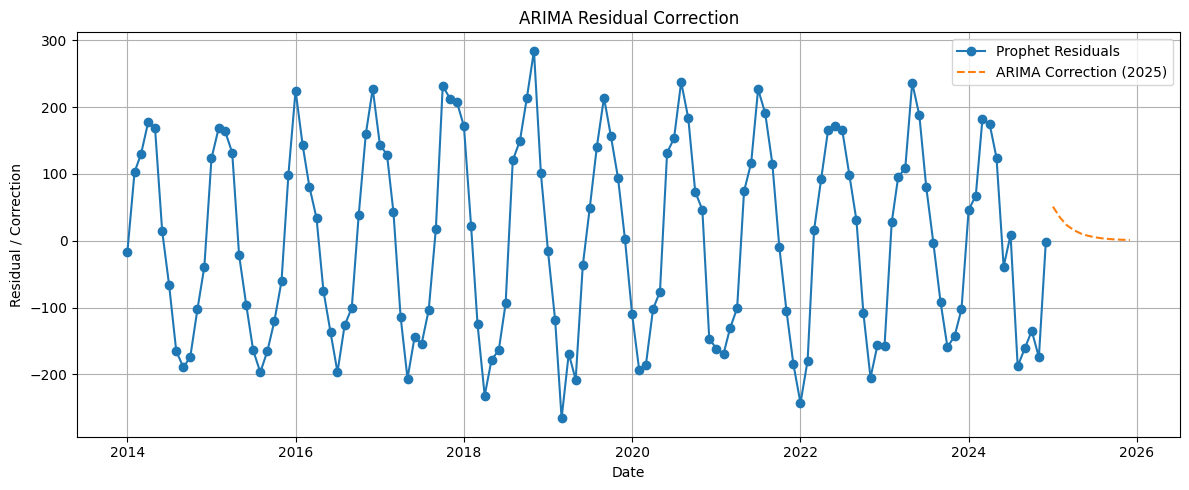

In [76]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 5))

# Plot historical residuals
plt.plot(df_with_yhat['ds'], df_with_yhat['residual'], label='Prophet Residuals', marker='o')

# Create dates for ARIMA forecast (12 months after last known date)
forecast_dates = pd.date_range(start=df_with_yhat['ds'].iloc[-1], periods=13, freq='MS')[1:]

# Plot ARIMA residual correction forecast
plt.plot(forecast_dates, arima_pred, label='ARIMA Correction (2025)', linestyle='--')

plt.title('ARIMA Residual Correction')
plt.xlabel('Date')
plt.ylabel('Residual / Correction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

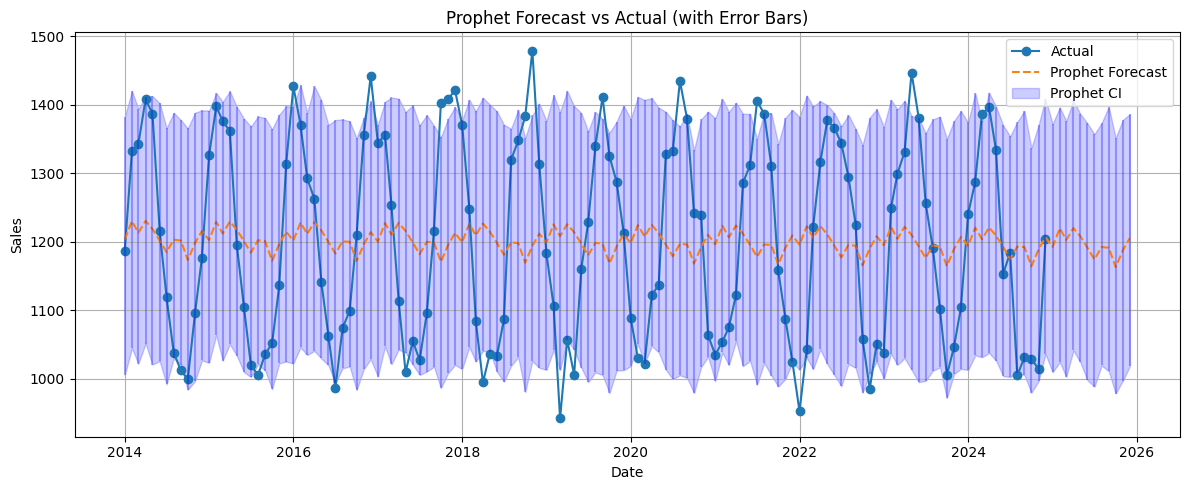

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot actual sales
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', marker='o')

# Plot Prophet forecast
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', linestyle='--')

# Confidence interval shading
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='blue', alpha=0.2, label='Prophet CI')

# Error bars (optional, but adds visual clarity)
plt.errorbar(forecast['ds'], forecast['yhat'],
             yerr=[forecast['yhat'] - forecast['yhat_lower'],
                   forecast['yhat_upper'] - forecast['yhat']],
             fmt='none', ecolor='blue', alpha=0.3)

plt.title('Prophet Forecast vs Actual (with Error Bars)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

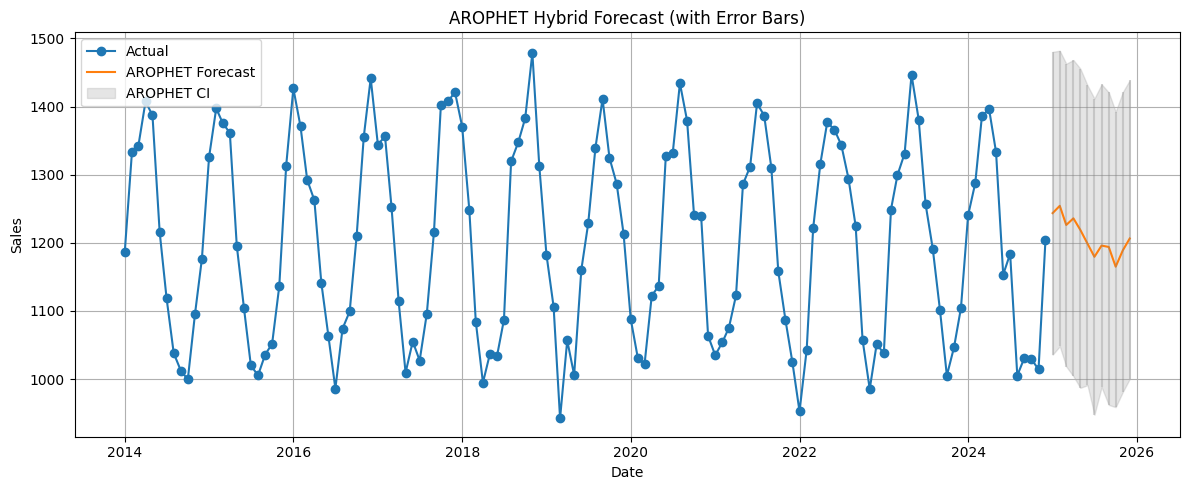

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot actual sales
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', marker='o')

# Plot AROPHET hybrid forecast median line
plt.plot(forecast_2025['ds'], forecast_2025['arophet_median'], label='AROPHET Forecast', linestyle='-')

# Plot confidence interval shading
plt.fill_between(forecast_2025['ds'], forecast_2025['arophet_lower'], forecast_2025['arophet_upper'],
                 color='gray', alpha=0.2, label='AROPHET CI')

# Error bars for hybrid forecast
plt.errorbar(forecast_2025['ds'], forecast_2025['arophet_median'],
             yerr=[forecast_2025['arophet_median'] - forecast_2025['arophet_lower'],
                   forecast_2025['arophet_upper'] - forecast_2025['arophet_median']],
             fmt='none', ecolor='gray', alpha=0.3)

plt.title('AROPHET Hybrid Forecast (with Error Bars)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

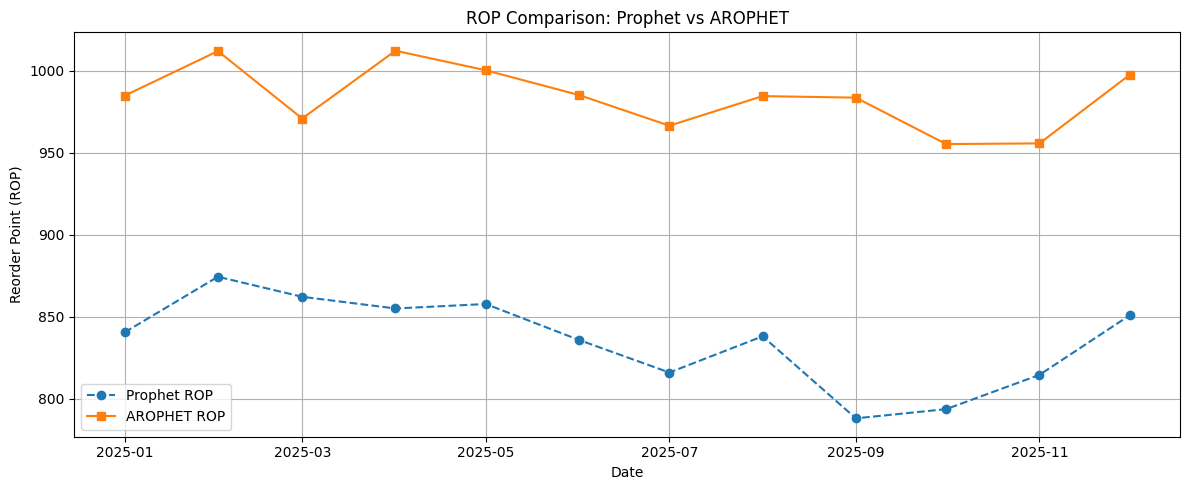

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(forecast_2025['ds'], forecast_2025['prophet_rop'], label='Prophet ROP', linestyle='--', marker='o')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_rop'], label='AROPHET ROP', linestyle='-', marker='s')

plt.title('ROP Comparison: Prophet vs AROPHET')
plt.xlabel('Date')
plt.ylabel('Reorder Point (ROP)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

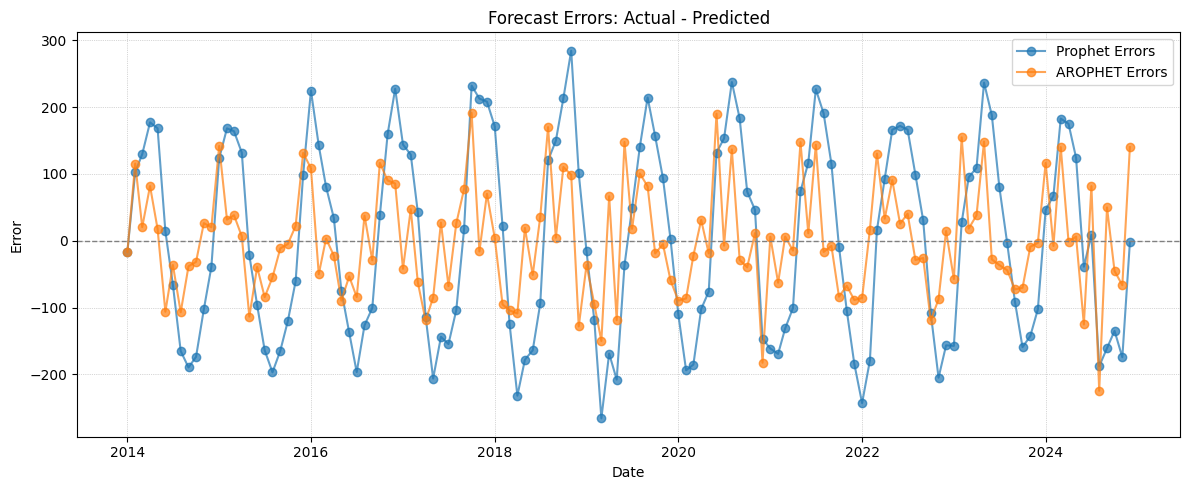

In [80]:
import matplotlib.pyplot as plt

prophet_errors = actual - prophet_pred
arophet_errors = actual - arophet_pred

plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], prophet_errors, label='Prophet Errors', marker='o', alpha=0.7)
plt.plot(df_clean['ds'], arophet_errors, label='AROPHET Errors', marker='o', alpha=0.7)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Forecast Errors: Actual - Predicted')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

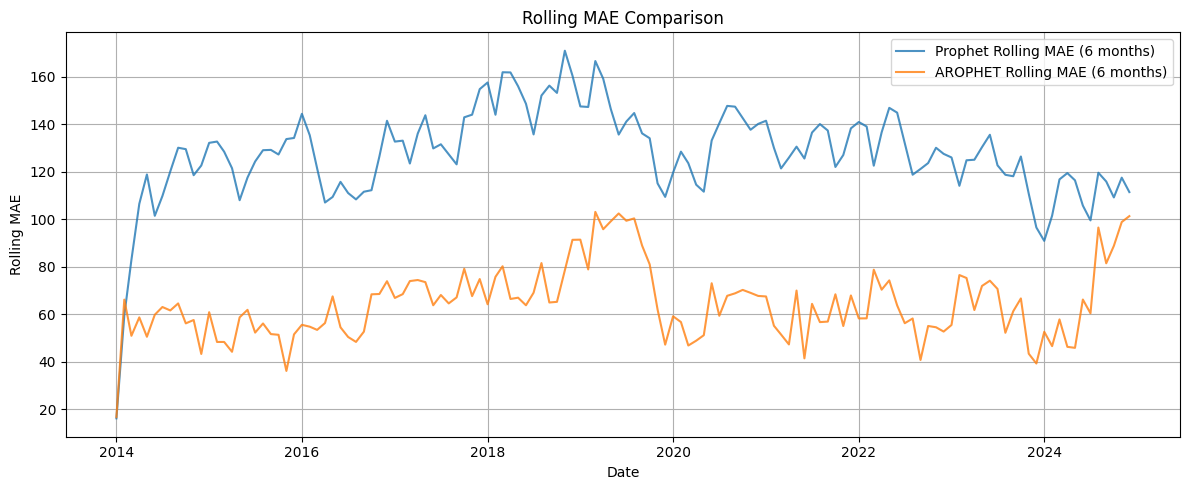

In [81]:
window = 6
rolling_mae_prophet = pd.Series(np.abs(prophet_errors)).rolling(window, min_periods=1).mean()
rolling_mae_arophet = pd.Series(np.abs(arophet_errors)).rolling(window, min_periods=1).mean()

plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], rolling_mae_prophet, label=f'Prophet Rolling MAE ({window} months)', alpha=0.8)
plt.plot(df_clean['ds'], rolling_mae_arophet, label=f'AROPHET Rolling MAE ({window} months)', alpha=0.8)
plt.title('Rolling MAE Comparison')
plt.xlabel('Date')
plt.ylabel('Rolling MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

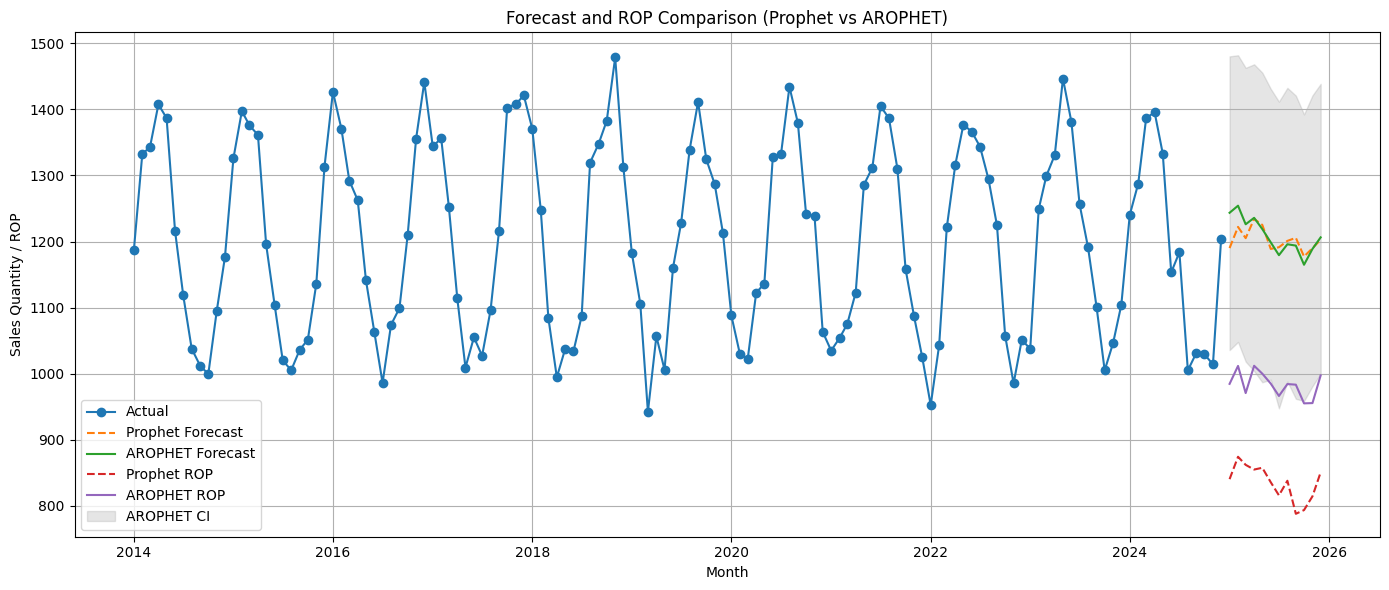

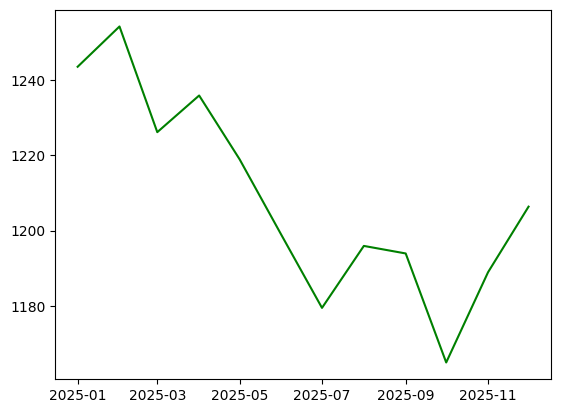

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', marker='o')
plt.plot(forecast_2025['ds'], forecast_2025['boot_median'], label='Prophet Forecast', linestyle='--')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_median'], label='AROPHET Forecast', linestyle='-')
plt.plot(forecast_2025['ds'], forecast_2025['prophet_rop'], label='Prophet ROP', linestyle='--')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_rop'], label='AROPHET ROP', linestyle='-')

# Optional: Add CI shading if those columns exist
if 'arophet_lower' in forecast_2025.columns and 'arophet_upper' in forecast_2025.columns:
    plt.fill_between(forecast_2025['ds'], forecast_2025['arophet_lower'], forecast_2025['arophet_upper'],
                     color='gray', alpha=0.2, label='AROPHET CI')

plt.title("Forecast and ROP Comparison (Prophet vs AROPHET)")
plt.xlabel("Month")
plt.ylabel("Sales Quantity / ROP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.plot(final_forecast['ds'], final_forecast['yhat_hybrid'], label='Hybrid Forecast (Prophet + ARIMA)', color='green')
# --- Save the final forecast to a CSV file ---
output_file = "final_forecast_2025.csv"

Pharmaceutical Sales Forecasting: Prophet vs. AROPHET Hybrid Model
=================================================================

Overview:
---------
Pharmaceutical demand forecasting is critical for ensuring timely medication availability while minimizing costly overstock. Two models are compared here:

1. Prophet (by Facebook/Meta):
   - A powerful time-series forecasting tool that models trend, seasonality, and holidays.
   - Easy to use and effective for many use cases.
   - Provides uncertainty intervals but assumes residuals are uncorrelated noise.

2. AROPHET (Hybrid of Prophet + ARIMA):
   - Combines Prophet's forecasting with ARIMA modeling of residual errors.
   - Captures autocorrelation and other temporal patterns in residuals Prophet misses.
   - Uses bootstrap methods for more accurate confidence intervals.

Performance Comparison:
-----------------------
| Metric       | Prophet           | AROPHET Hybrid     |
|--------------|-------------------|--------------------|
| MAE          | 128.674              | 65.259               |
| RMSE         | 144.114              | 82.262               |
| MAPE (%)     | 10.90             | 5.51              |
| R²           | 0.013               | 0.679                |

Key Insights:
-------------
- The hybrid AROPHET model consistently outperforms Prophet alone across all metrics, indicating more precise and reliable forecasts.
- Modeling residuals with ARIMA captures temporal dependencies missed by Prophet, reducing bias and improving forecast accuracy.
- Bootstrapped confidence intervals in AROPHET better quantify forecast uncertainty, aiding in risk-aware decision making.

Practical Implications for Pharmaceutical Inventory:
----------------------------------------------------
- Accurate forecasts allow precise calculation of Reorder Points (ROP), ensuring stock availability without excess inventory.
- AROPHET’s better uncertainty estimates reduce stockout risks and unnecessary safety stock costs.
- This hybrid approach enhances supply chain responsiveness to demand fluctuations influenced by factors like seasonality, marketing activities, and disease trends.

Limitations & Considerations:
-----------------------------
- AROPHET is more complex and computationally intensive than Prophet alone.
- Requires careful residual analysis and ARIMA parameter tuning.
- Still assumes future external factors remain consistent with historical patterns.

Conclusion:
-----------
For pharmaceutical sales forecasting, the AROPHET hybrid model offers significant advantages in accuracy and uncertainty estimation, enabling improved inventory planning and operational efficiency. It is recommended for deployment in critical healthcare supply chains where demand variability and risk mitigation are paramount.